In [99]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import datetime

from openmovement.load import CwaData

## Data extraction Using `openmovement` library

In [100]:
def extract_data(filename):
    with CwaData(filename, include_gyro=True, include_temperature=True) as cwa_data:
        # As an ndarray of [time,accel_x,accel_y,accel_z,temperature]
        sample_values = cwa_data.get_sample_values()
        space_values = sample_values[:, 1:4]
        norms = np.linalg.norm(space_values, axis=1)
        space_values = np.column_stack((space_values, norms))
        time_index = sample_values[:, 0]
        
        # As a pandas DataFrame
        samples = cwa_data.get_samples()

    return {
        'filename': filename,
        'space_values': space_values,
        'time_index': time_index,
        'df': samples
    }

def extract_patient(pt_number):
    # load the data
    non_paretic = extract_data(f'data/ReArm_{pt_number}_ac_np.cwa')
    paretic = extract_data(f'data/ReArm_{pt_number}_ac_p.cwa')

    # remove the beginning of the earlier dataset to make the start times match
    start = max(non_paretic['time_index'][0], paretic['time_index'][0])

    non_paretic['space_values'] = non_paretic['space_values'][non_paretic['time_index'] >= start]
    non_paretic['time_index'] = non_paretic['time_index'][non_paretic['time_index'] >= start]

    paretic['space_values'] = paretic['space_values'][paretic['time_index'] >= start]
    paretic['time_index'] = paretic['time_index'][paretic['time_index'] >= start]

    # remove the end of the longer dataset to make the lengths match
    length = min(non_paretic['time_index'].shape[0], paretic['time_index'].shape[0])
    
    non_paretic['space_values'] = non_paretic['space_values'][:length]
    non_paretic['time_index'] = non_paretic['time_index'][:length]

    paretic['space_values'] = paretic['space_values'][:length]
    paretic['time_index'] = paretic['time_index'][:length]

    # define the time index
    time_index = (non_paretic['time_index'] + paretic['time_index']) / 2

    space_values = np.stack((non_paretic['space_values'], paretic['space_values']), axis=1)
    
    return space_values, time_index

In [101]:
space_values, time_index = extract_patient("C1P08_20210810_1")

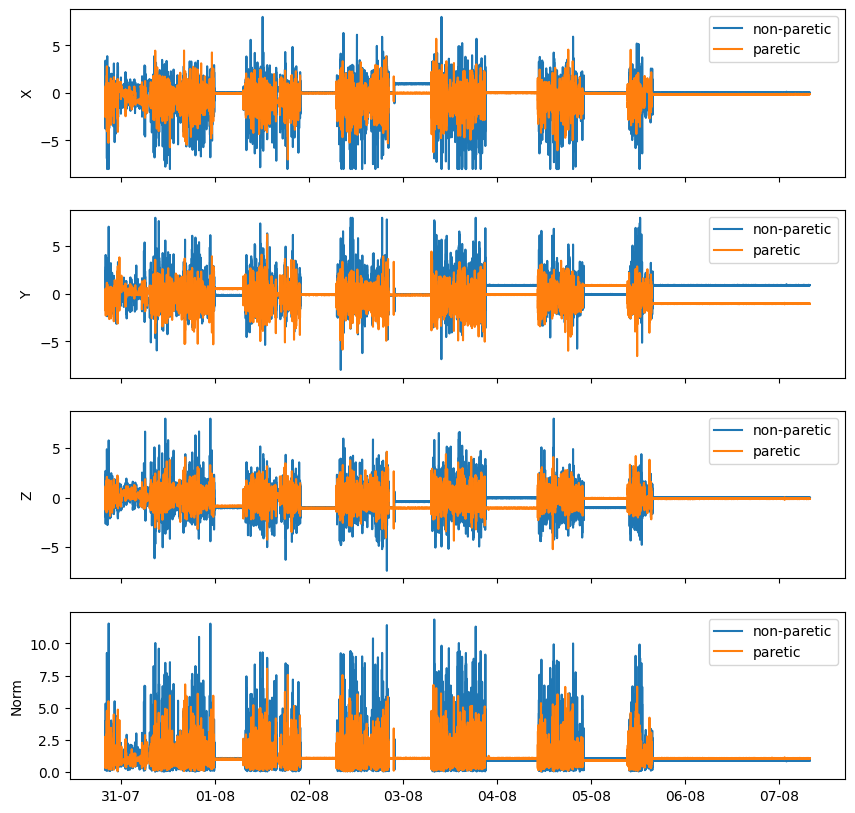

In [102]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(4):
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 0, i], label='non-paretic')
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 1, i], label='paretic')
    ax[i].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
    ax[i].legend(loc='upper right')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.show()

## Jerk

In [103]:
space_values.shape

(32669316, 2, 4)

In [104]:
# J_i(t)=\frac{a_i(t+d t)-a_i(t-d t)}{2 d t},

jerk_xyz = (space_values[2:, :, 0:3] - space_values[:-2, :, 0:3]) / (2 * (time_index[2] - time_index[0]))
jerk_norm = np.linalg.norm(jerk_xyz, axis=2)
jerk_norm = jerk_norm.reshape(jerk_norm.shape[0], jerk_norm.shape[1], 1)

# small number to avoid division par zero
eps = 1e-6

jerk = np.concatenate((jerk_xyz, jerk_norm), axis=2) + eps

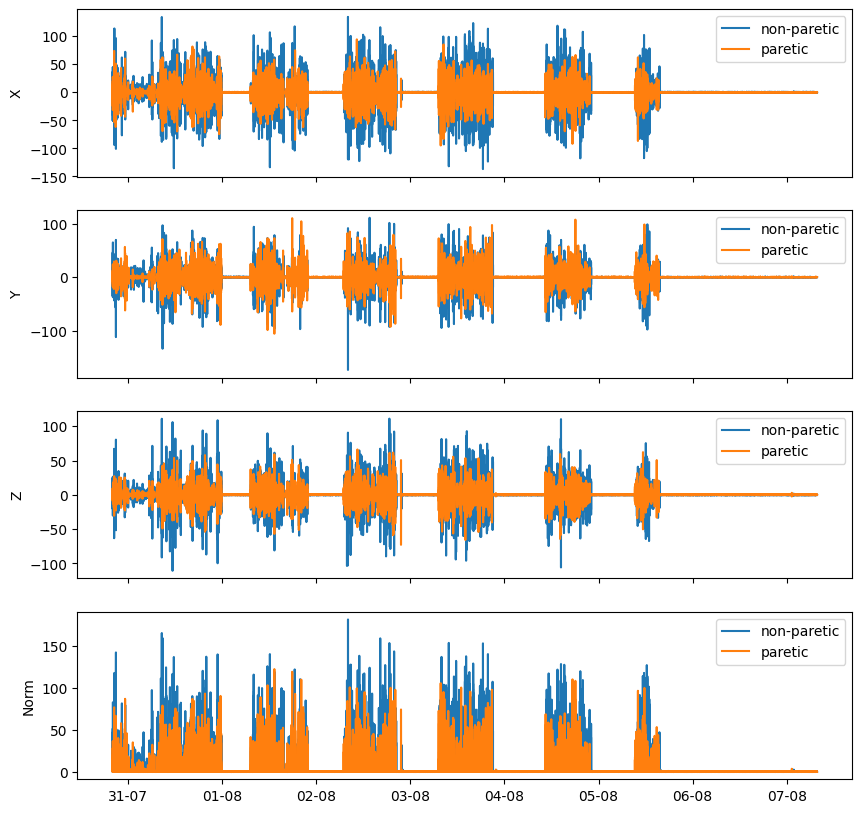

In [105]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(4):
    ax[i].plot(pd.to_datetime(time_index[1:-1], unit='s'), jerk[:, 0, i], label='non-paretic')
    ax[i].plot(pd.to_datetime(time_index[1:-1], unit='s'), jerk[:, 1, i], label='paretic')
    ax[i].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
    ax[i].legend(loc='upper right')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.show()

In [106]:
# \operatorname{Jerk}_{\text {Ratio }}=2 x \frac{\mid \text { Jerk }_{\text {paretic }} \mid}{\mid \text { Jerk }_{\text {pareetic }}|+| \text { Jerk }_{\text {non-paretic }}}

jerk_ratio = 2 * np.abs(jerk[:, 1, 3]) / (np.abs(jerk[:, 0, 3]) + np.abs(jerk[:, 1, 3]))

(array([7.964535e+06, 6.628500e+04, 1.280120e+05, 1.733050e+05,
        1.997750e+05, 2.135340e+05, 2.216800e+05, 2.209870e+05,
        2.188510e+05, 2.152130e+05, 2.153370e+05, 2.022580e+05,
        2.000610e+05, 1.932590e+05, 1.917550e+05, 1.647330e+05,
        1.979380e+05, 1.552320e+05, 1.535930e+05, 1.884030e+05,
        1.244910e+05, 1.853730e+05, 1.171230e+05, 1.417820e+05,
        1.430580e+05, 1.895200e+05, 1.114680e+05, 1.156900e+05,
        1.767060e+05, 1.030400e+05, 2.118290e+05, 8.168400e+04,
        1.186530e+05, 1.342640e+05, 8.449500e+04, 8.763400e+04,
        2.095530e+05, 8.441400e+04, 1.296930e+05, 7.045000e+04,
        8.182200e+04, 9.152190e+05, 7.742400e+04, 8.185300e+04,
        1.262670e+05, 5.993000e+04, 7.004100e+04, 8.020200e+04,
        6.027400e+04, 4.384400e+04, 8.594239e+06, 5.722600e+04,
        7.597100e+04, 6.219000e+04, 5.187100e+04, 1.162060e+05,
        6.605600e+04, 6.175300e+04, 8.311120e+05, 6.108600e+04,
        5.108800e+04, 9.006600e+04, 5.71

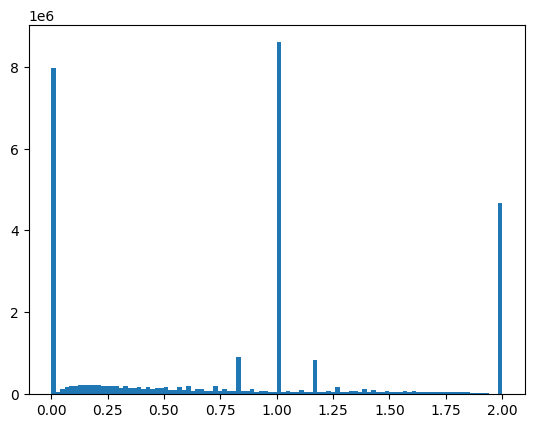

In [107]:
# histogram of jerk ratio
plt.hist(jerk_ratio, bins=100)

## Functional

In [108]:
space_values.shape

(32669316, 2, 4)

In [109]:
#\alpha(t)=\operatorname{arcos}\left(\frac{a_y(t)}{E N(t)}\right)
alpha = np.arccos(space_values[:, :, 1] / space_values[:, :, 3])

In [110]:
alpha.shape

(32669316, 2)

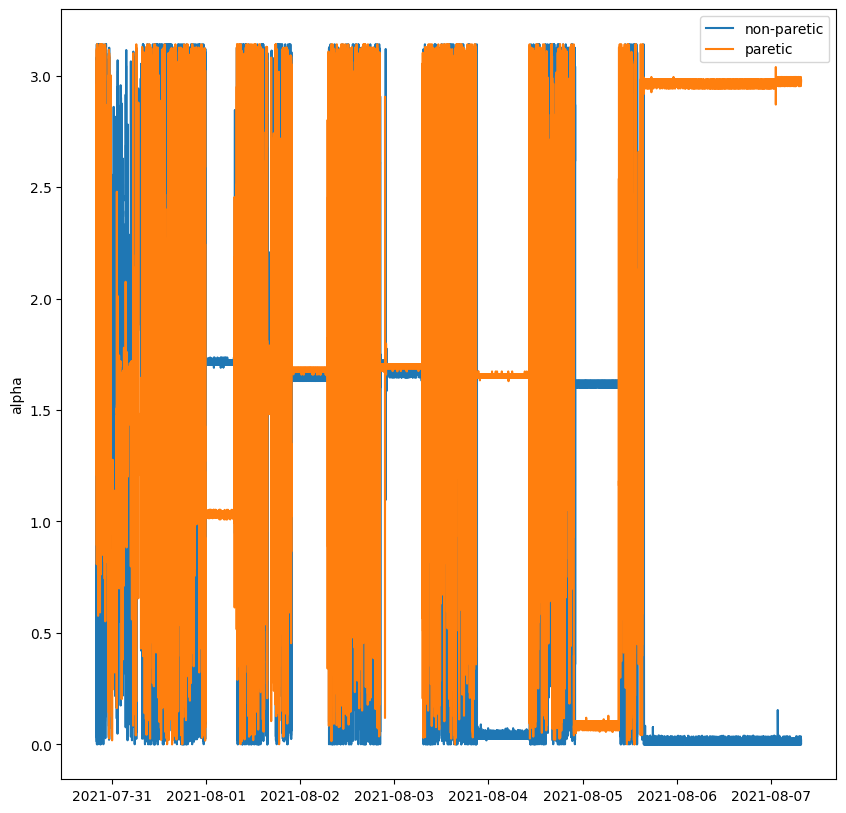

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), sharex=True)

ax.plot(pd.to_datetime(time_index, unit='s'), alpha[:, 0], label='non-paretic')
ax.plot(pd.to_datetime(time_index, unit='s'), alpha[:, 1], label='paretic')
ax.set_ylabel('alpha')
ax.legend(loc='upper right')


In [112]:
def partition(space_values, time_index, seconds_per_window=5):
    delta_t = float(np.diff(time_index).mean())

    number_timepoints = space_values.shape[0]
    number_arms = space_values.shape[1]
    number_axis= space_values.shape[2]

    # partition the data into windows
    window_size = int(seconds_per_window * 60 / delta_t)
    num_windows = number_timepoints // window_size

    print(f"delta_t: {delta_t}")
    print(f"window_size: {window_size}")
    print(f"num_windows: {num_windows}")

    space_values = space_values[:num_windows * window_size]
    space_values = space_values.reshape((num_windows, window_size, number_arms, number_axis))

    time_index = time_index[:num_windows * window_size]
    time_index = time_index.reshape((num_windows, window_size))
    
    return space_values, time_index

In [113]:
windows, time_indexes = partition(space_values, time_index, seconds_per_window=0.5)

alphas = np.arccos(windows[:, :, :, 1] / windows[:, :, :, 3])

delta_t: 0.019807240904446525
window_size: 1514
num_windows: 21578


In [114]:
alphas.shape

(21578, 1514, 2)

In [115]:
#|\alpha| \leq 30^{\circ} \text { and } \alpha_{\text {max }}-\alpha_{\text {min }} \geq 30^{\circ} 
is_functional = (np.abs(alphas - np.deg2rad(90)) <= np.deg2rad(30)).all(axis=1) & ((alphas.max(axis=1) - alphas.min(axis=1)) >= np.deg2rad(30))

In [116]:
# count trues
is_functional.sum()

np.int64(306)

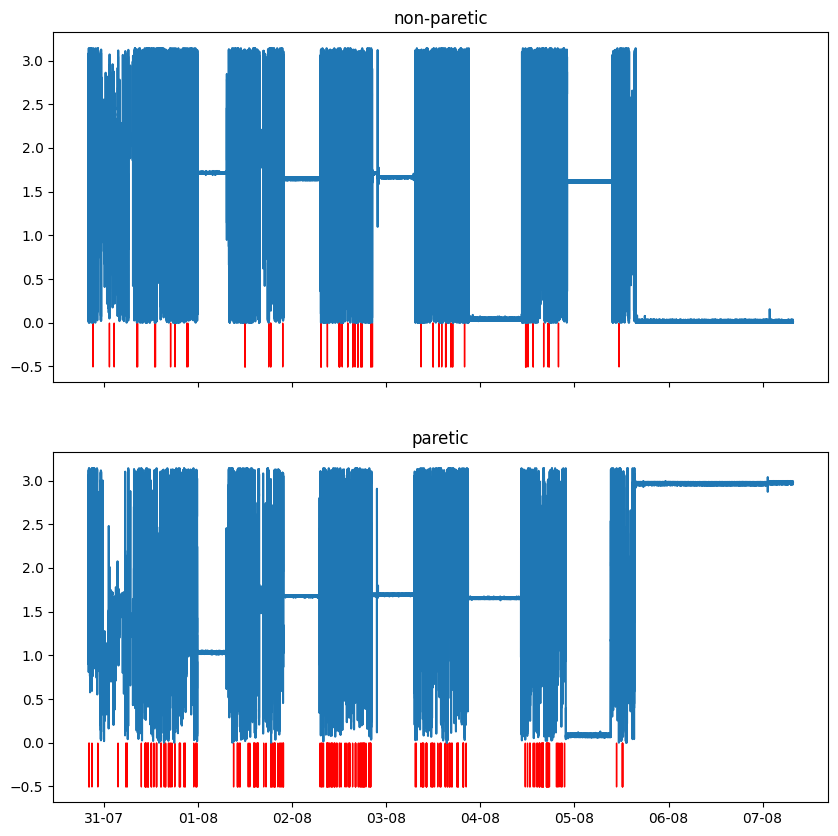

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

for i in range(2):
    ax[i].plot(pd.to_datetime(time_index, unit='s'), alpha[:, i])
    ax[i].set_title(['non-paretic', 'paretic'][i])

    for j in range(len(time_indexes)):
        if is_functional[j, i]:
            ax[i].fill_between(pd.to_datetime(time_indexes[j], unit='s'), -0.5, 0, color='red')
        
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))

